In [1]:
#For Downloading the dataset on colab

#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/test_images-v0.4.tar.gz
#!wget https://datasets.aicrowd.com/default/aicrowd-public-datasets/food-recognition-challenge/v0.4/train-v0.4.tar.gz

In [2]:
#!unzip train-v0.4.tar.gz

In [3]:
#Extract dataset from the tar files
#!for f in *.tar.gz; do tar xf "$f"; done

In [4]:
#%pip install git+https://github.com/tensorflow/examples

In [5]:
#%pip install git+https://github.com/AIcrowd/coco.git#subdirectory=PythonAPI

In [6]:
import tensorflow as tf
from keras import backend as K
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from google.colab import drive

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

import random

import cv2

import skimage.io as io

from pycocotools import mask as cocomask

import os

#drive.mount('/content/drive')

**Loading the data**

In [7]:
from pycocotools.coco import COCO

#Loading the coco annotations
folder_loc = "/home/belericks7/Documenti/deep_learning"

coco_train = COCO(folder_loc + '/train/annotations.json')
coco_val = COCO(folder_loc + '/val/annotations.json')


loading annotations into memory...
Done (t=1.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


**Exploring the data**

In [8]:
def plot_image(image_id):
    #read the image
    img = coco_train.loadImgs(image_id)[0]
    image = mpimg.imread(folder_loc + '/train/images/' + img['file_name'])
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco_train.loadAnns(coco_train.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k'][i]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.8)
  
    #show results
    plt.show()

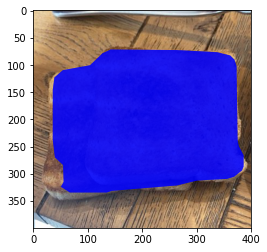

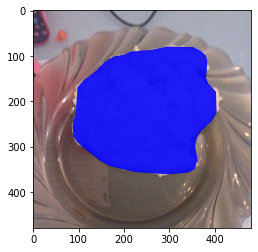

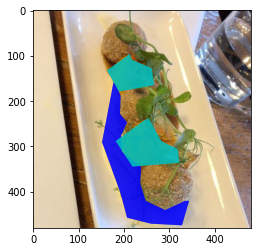

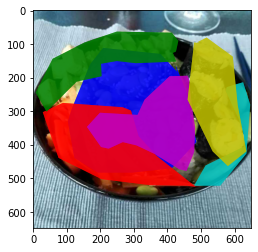

In [9]:
#Plotting a few random images

np.random.seed(100)
img_num = []
rand = np.random.randint(0, len(coco_train.getImgIds()), 4)
for i in rand:
    img_num.append(coco_train.getImgIds()[i])
for ids in img_num:
    plot_image(ids)

**Loading and cleaning the data**

In [10]:
# display COCO categories
categories = coco_train.loadCats(coco_train.getCatIds())
class_names=[cat['name'] for cat in categories]
print('COCO categories: ', len(class_names))

COCO categories:  273


Sorting the category ids by popularity

In [11]:
def get_category_ids():
    catIds_raw = coco_train.getCatIds()
    catIds = []
    for cat in catIds_raw:
          catIds.append([len(coco_train.getImgIds(catIds=cat)), cat])
    catIds.sort()
    cat_ids = [cat_num[1] for cat_num in catIds ]
    return cat_ids

Image Filtering

In [12]:
def filterDataset(folder, mode='train'):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}/annotations.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

Useful functions

In [13]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

Generate the images and masks

In [14]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size, batch_size, mode, mask_type):
    
    img_folder = '{}/{}/images'.format(folder, mode)
    dataset_size = len(images)
    catIds = get_category_ids()
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [15]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
 
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                ax.imshow(mask[j][:,:,0]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

In [16]:
images, dataset_size, coco = filterDataset(folder_loc,'train')

loading annotations into memory...
Done (t=1.62s)
creating index...
index created!


In [17]:
#images=[]
#for ids in img_num:
    #img = coco_train.loadImgs(ids)[0]
    #images.append(img)

In [18]:
batch_size = 4
input_image_size = (256,256)
mask_type = 'normal'

val_gen = dataGeneratorCoco(images, class_names, coco, folder_loc,
                            input_image_size, batch_size, 'train', mask_type)

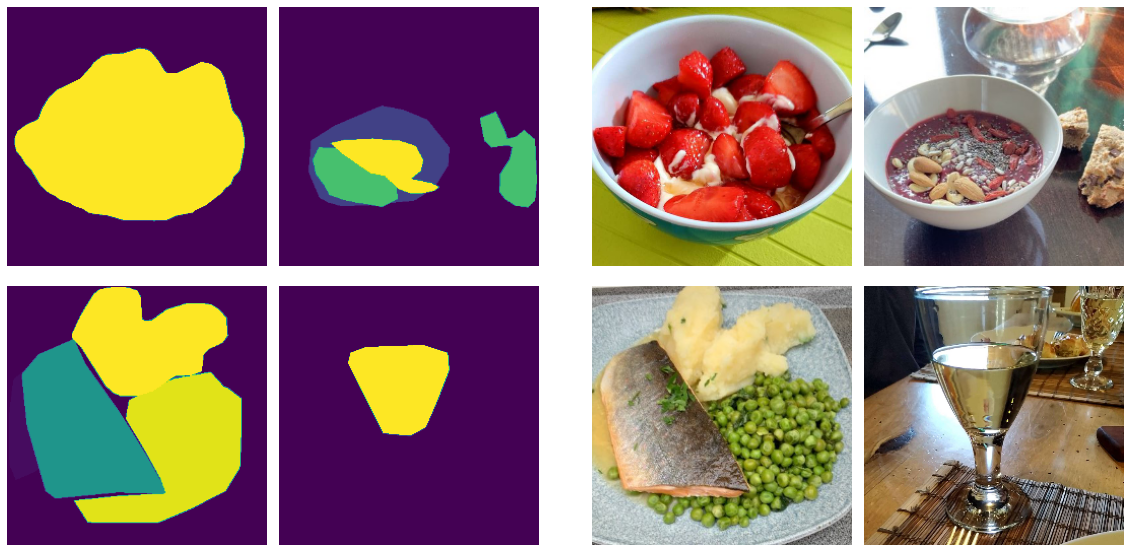

In [28]:
visualizeGenerator(val_gen)

Data augmentation

In [20]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [21]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

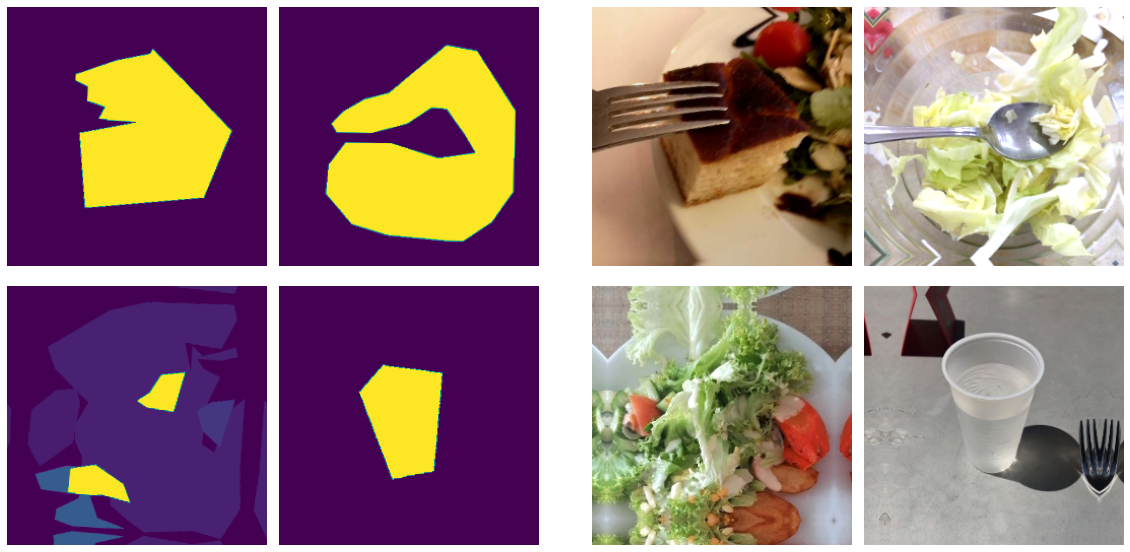

In [27]:
visualizeGenerator(aug_gen)

In [ ]:
n_epochs = 50

steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size

m = <model>
opt = <optimizer>
lossFn = <loss function>

# Compile your model first
m.compile(loss = lossFn, optimizer = opt, metrics=['accuracy'])

# Start the training process
history = m.fit(x = train_gen_aug,
                validation_data = val_gen_aug,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                verbose = True)